#### <b> QF621 - Group Project

In [98]:
# 1.) import necessary library and raw data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas_ta as ta
from datetime import datetime
warnings.filterwarnings('ignore')

raw_data = pd.read_csv('combine_data_weekly.csv')

#### <b> 1.) Import S&P 500 weekly data to use as a benchmark

In [99]:
# 2.) import sp500 data weekly

import yfinance as yf
import pandas as pd

# Define the ticker and download data
ticker = "^GSPC"
sp500 = yf.download(ticker, start="2018-06-16", end="2024-06-10")

# Resample to weekly frequency, using 'W-FRI' to ensure the weeks end on Friday
sp500_weekly = sp500.resample('W-Mon').agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Adj Close': 'last',
    'Volume': 'sum'
})

sp500_weekly['Return'] = sp500_weekly['Close'].pct_change()
sp500_weekly['Cumulative Return'] = (1 + sp500_weekly['Return']).cumprod() - 1

[*********************100%%**********************]  1 of 1 completed


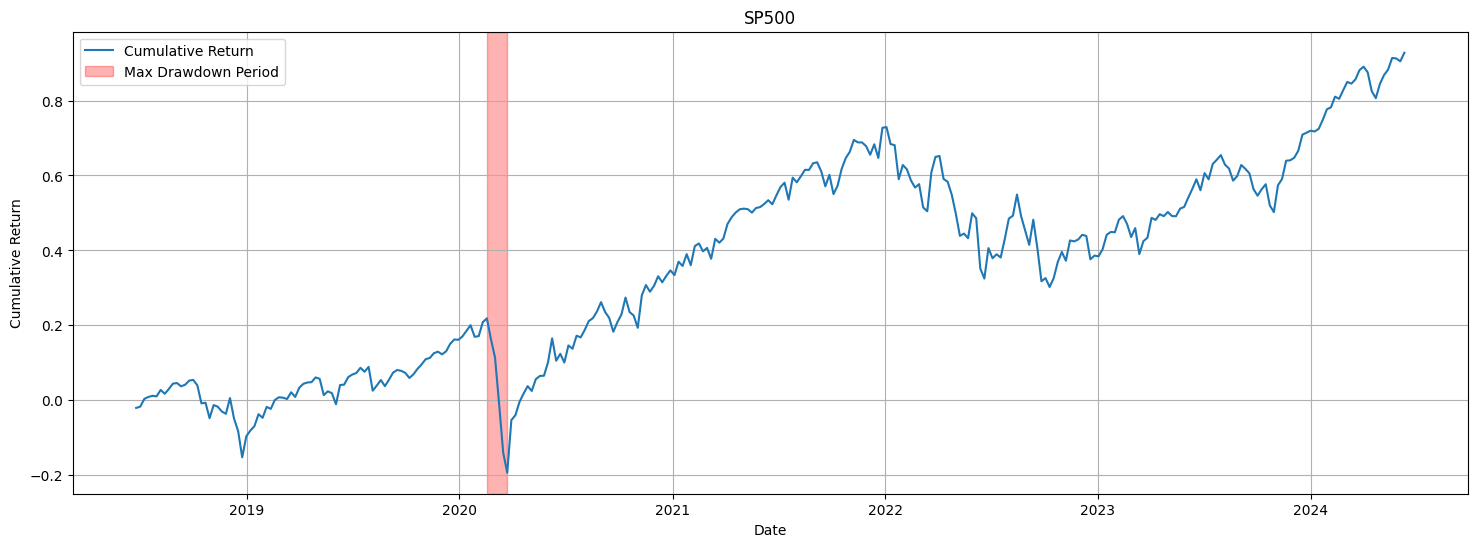

,Metric,Value
0,Average Daily Return,0.002472
1,Volatility (Weekly),0.027083
2,Volatility (Annualized),0.195299
3,Cumulative Return,0.927712
4,Sharpe Ratio,0.701513
5,Maximum Drawdown,-0.338079


In [100]:
# function to show plot and performance of sp500

def perf_m(df, plt_title):

    # 1. Calculate average daily return
    average_daily_return = df['Return'].mean()
    # 2. Calculate volatility (standard deviation of daily returns)
    volatility = df['Return'].std()
    # Annualize the volatility (assuming 252 trading days in a year)
    annualized_volatility = volatility * np.sqrt(52)
    # 3. Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
    sharpe_ratio = (((1+average_daily_return)**52-1) / annualized_volatility)
    # 4. Calculate cumulative return
    df['Cumulative Return'] = (1 + df['Return']).cumprod() - 1
    cumulative_return = df["Cumulative Return"].iloc[-1]
    # 5. Calculate maximum drawdown
    cumulative_return_series = (1 + df['Return']).cumprod()
    rolling_max = cumulative_return_series.cummax()
    drawdown = cumulative_return_series / rolling_max - 1
    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    start_date = (cumulative_return_series[:end_date]).idxmax()
    # Create a dataframe with the calculated metrics
    metrics = {
        'Metric': ['Average Daily Return', 'Volatility (Weekly)', 'Volatility (Annualized)', 
                'Cumulative Return', 'Sharpe Ratio', 'Maximum Drawdown'],
        'Value': [average_daily_return, volatility, annualized_volatility, 
                cumulative_return, sharpe_ratio, max_drawdown]
    }

    metrics_df = pd.DataFrame(metrics)

    plt.figure(figsize=[18, 6])
    plt.plot(df.index, df['Cumulative Return'], label='Cumulative Return')
    plt.axvspan(start_date, end_date, color='red', alpha=0.3, label='Max Drawdown Period')
    plt.title(plt_title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    display(metrics_df)
    return metrics_df

sp500_metric = perf_m(sp500_weekly, "SP500")

##### <b>Daily Long-Short power

In [101]:
# 1.) Calculate the factor

df = raw_data.copy()
df = df[df["Date"] >= '2018-06-01']
df_with_DLS = pd.DataFrame()
for ticker in df["Ticker"].unique():
    df_filtered = df[df["Ticker"] == ticker]
    df_filtered['daily_long_short'] = np.arctan((df_filtered['High'] - df_filtered['Close']) / (df_filtered['Close'] - df_filtered['Low'])) / (np.pi / 2)
    # df_filtered['L_S_power'] = (df_filtered['Close']-df_filtered['Low'])/(df_filtered['High']-df_filtered['Close'])
    # df_filtered['daily_long_short'] = np.arctan(df_filtered['L_S_power']) / (np.pi / 2)
    
    df_filtered['Norm_ret'] = (df_filtered['Close'] - df_filtered['Open']) / df_filtered['Open']
    df_with_DLS = pd.concat([df_with_DLS, df_filtered], axis = 0)

df_with_DLS = df_with_DLS[df_with_DLS["Ticker"] != "QRVO"]

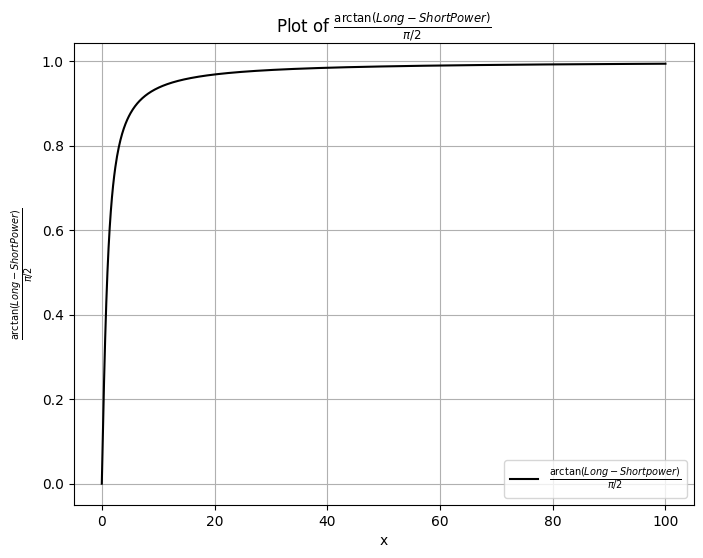

In [102]:
# 2.) Mapping of the factor

import numpy as np
import matplotlib.pyplot as plt

def plot_arctan_equation():
    # Generate values for x ranging from -100 to 100
    x = np.linspace(0, 100, 1000)
    
    # Calculate the corresponding y values for the equation arctan(x) / (pi / 2)
    y = np.arctan(x) / (np.pi / 2)
    
    # Plot the equation
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label=r'$\frac{\arctan(Long-Short power)}{\pi / 2}$', color = 'black')
    plt.xlabel('x')
    plt.ylabel(r'$\frac{\arctan(Long-Short Power)}{\pi / 2}$')
    plt.title(r'Plot of $\frac{\arctan(Long-Short Power)}{\pi / 2}$')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the equation
plot_arctan_equation()

In [103]:
df_with_DLS["shift_ret"] = df_with_DLS["Norm_ret"].shift(-1)
df_with_DLS

,Ticker,Date,Open,High,Low,Close,Adj Close,Volume,daily_long_short,Norm_ret,shift_ret
207,MMM,2018-06-04,167.834442,172.867889,167.282608,172.734116,130.074066,13635835.0,0.015619,0.029193,-0.007842
208,MMM,2018-06-11,172.734116,172.901337,167.316055,171.379593,129.054062,16597968.0,0.228114,-0.007842,-0.029773
209,MMM,2018-06-18,169.339462,171.045151,162.700668,164.297653,123.721123,15677647.0,0.852049,-0.029773,0.003776
210,MMM,2018-06-25,163.862869,167.140472,161.906357,164.481598,123.859673,15072829.0,0.510171,0.003776,0.010232
211,MMM,2018-07-02,163.428101,166.346161,161.797653,165.100327,124.325584,7999087.0,0.229639,0.010232,0.015343
...,...,...,...,...,...,...,...,...,...,...,...
254770,ZTS,2024-05-13,169.429993,174.990005,167.800003,174.059998,174.059998,10456000.0,0.093892,0.027327,-0.020278
254771,ZTS,2024-05-20,173.589996,175.779999,169.729996,170.070007,170.070007,9270300.0,0.962136,-0.020278,-0.002823
254772,ZTS,2024-05-27,170.039993,174.169998,167.960007,169.559998,169.559998,12368600.0,0.787330,-0.002823,0.040461
254773,ZTS,2024-06-03,170.039993,177.119995,169.660004,176.919998,176.919998,9859500.0,0.017533,0.040461,-0.004078


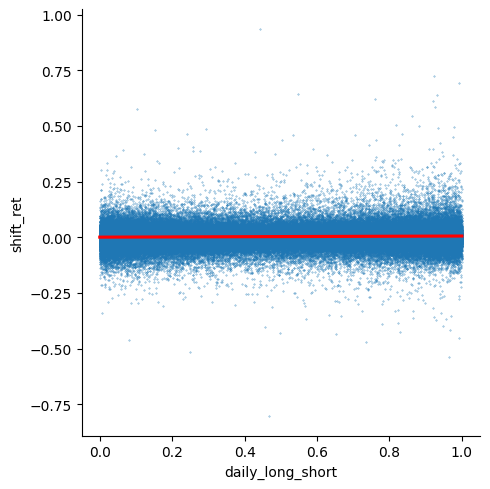

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the scatter plot with regression line using seaborn
sns.lmplot(x='daily_long_short', y='shift_ret', data=df_with_DLS, scatter_kws={'s': 0.1}, line_kws={'color': 'red'})

# Display the plot
plt.show()

In [105]:
# 2.) Backtesting

def backtestingwithtfsl_3(df, factor_weights, stock_weights, trading_fee=0.025/100, stop_loss = 0.02):
    dfs = df.copy()
    dfs.reset_index(inplace = True)
    dfs['ranking_parameter'] = dfs['daily_long_short']
    dfs['next_date'] = dfs['Date'].shift(-1)
    dfs['next_Norm_ret'] = dfs['Norm_ret'].shift(-1)
    dfs['next_open'] = dfs['Open'].shift(-1)
    dfs['next_low'] = dfs['Low'].shift(-1)
    dfs['next_high'] = dfs['High'].shift(-1)

    # try
    # dfs = dfs[dfs["daily_long_short"] < 0.95]
    # display(dfs)

    ranking_df = dfs.pivot(index="Date", columns='Ticker', values='ranking_parameter')
    # ranking_df = ranking_df[ranking_df.isnull().mean(axis=1) < 0.9]
    # display(dfs)
    # display(ranking_df)
    portfolio_return = {}
    portfolio_return["Date"] = []
    portfolio_return["Daily Return"] = []

    for date in ranking_df[0:-1].index:
        dfs_filter = dfs[dfs['Date'] == date]
        top_5 = dfs_filter.nlargest(10, 'ranking_parameter')
        bottom_5 = dfs_filter.nsmallest(10, 'ranking_parameter')
        selected_stocks = pd.concat([top_5, bottom_5])
        # display(selected_stocks[["daily_long_short","next_Norm_ret"]])
        return_next_day = selected_stocks['next_Norm_ret'].reset_index(drop=True)
        price_open= selected_stocks['next_open'].reset_index(drop=True)
        price_low = selected_stocks['next_low'].reset_index(drop=True)
        price_high = selected_stocks['next_high'].reset_index(drop=True)

        # Determine if stop-loss is hit
        stop_loss_long = (price_low / price_open - 1) < -stop_loss
        stop_loss_short = (price_high / price_open - 1) > stop_loss
        
        adjusted_returns = return_next_day.copy()
        adjusted_returns[:10] = adjusted_returns[:10].where(~stop_loss_long[:10], -stop_loss)
        adjusted_returns[10:] = adjusted_returns[10:].where(~stop_loss_short[10:], stop_loss)

        # Calculate returns including trading fees
        gross_return = (pd.Series(stock_weights) * adjusted_returns).values.sum()
        trade_cost = trading_fee * 2 * len(selected_stocks) * 0.1  # 2 trades (entry and exit) per stock
        net_return = gross_return - trade_cost

        portfolio_return["Date"].append(selected_stocks["next_date"].iloc[0])
        portfolio_return["Daily Return"].append(net_return)

        # if date == ranking_df.iloc[106,:].name:
        #     display(selected_stocks)
        #     display(return_next_day)
        #     display(price_open)
        #     display(price_low)
        #     display(stop_loss_long)
        #     display(stop_loss_short)
        #     display(adjusted_returns)
        #     display(gross_return)
        #     display(trade_cost)
        #     display(net_return)

    return_df = pd.DataFrame(portfolio_return)
    return_df.set_index("Date", inplace=True)
    
    return return_df

def perf_m_s(df, sp500 ,plt_title):

    df.reset_index(inplace = True)
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace = True)
    # 1. Calculate average daily return
    average_daily_return = df['Daily Return'].mean()
    # 2. Calculate volatility (standard deviation of daily returns)
    volatility = df['Daily Return'].std()
    # Annualize the volatility (assuming 252 trading days in a year)
    annualized_volatility = volatility * np.sqrt(52)
    # 3. Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
    sharpe_ratio = (((1 + average_daily_return)** 52 - 1) / annualized_volatility)
    # 4. Calculate cumulative return
    df['Cumulative Return'] = (1 + df['Daily Return']).cumprod() - 1
    cumulative_return = df["Cumulative Return"].iloc[-1]
    # 5. Calculate maximum drawdown
    cumulative_return_series = (1 + df['Daily Return']).cumprod()
    rolling_max = cumulative_return_series.cummax()
    drawdown = cumulative_return_series / rolling_max - 1
    max_drawdown = drawdown.min()
    end_date = drawdown.idxmin()
    start_date = (cumulative_return_series[:end_date]).idxmax()
    # Create a dataframe with the calculated metrics
    metrics = {
        'Metric': ['Average Daily Return', 'Volatility (Daily)', 'Volatility (Annualized)', 
                'Cumulative Return', 'Sharpe Ratio', 'Maximum Drawdown'],
        'Value': [average_daily_return, volatility, annualized_volatility, 
                cumulative_return, sharpe_ratio, max_drawdown]
    }

    # SP500
    # 1. Calculate average daily return
    average_daily_return_2 = sp500['Return'].mean()
    # 2. Calculate volatility (standard deviation of daily returns)
    volatility_2 = sp500['Return'].std()
    # Annualize the volatility (assuming 252 trading days in a year)
    annualized_volatility_2 = volatility_2 * np.sqrt(252)
    # 3. Calculate Sharpe Ratio (assuming risk-free rate is 0 for simplicity)
    sharpe_ratio_2 = (average_daily_return_2 / volatility_2) * np.sqrt(252)
    # 4. Calculate cumulative return
    sp500['Cumulative Return'] = (1 + sp500['Return']).cumprod() - 1
    cumulative_return_2 = sp500["Cumulative Return"].iloc[-1]
    # 5. Calculate maximum drawdown
    cumulative_return_series_2 = (1 + sp500['Return']).cumprod()
    rolling_max_2 = cumulative_return_series_2.cummax()
    drawdown_2 = cumulative_return_series_2 / rolling_max_2 - 1
    max_drawdown_2 = drawdown_2.min()
    end_date_2 = drawdown_2.idxmin()
    start_date_2 = (cumulative_return_series_2[:end_date_2]).idxmax()

    metrics_df = pd.DataFrame(metrics)

    plt.figure(figsize=[18, 6])
    plt.plot(df.index, df['Cumulative Return'], label='Cumulative Return')
    plt.plot(sp500.index, sp500['Cumulative Return'], label = "SP500")
    plt.axvspan(start_date, end_date, color='red', alpha=0.3, label='Max Drawdown Period')
    plt.axvspan(start_date_2, end_date_2, color='red', alpha=0.1, label='Max Drawdown Period - SP500')
    plt.title(plt_title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    display(metrics_df)

    return metrics_df

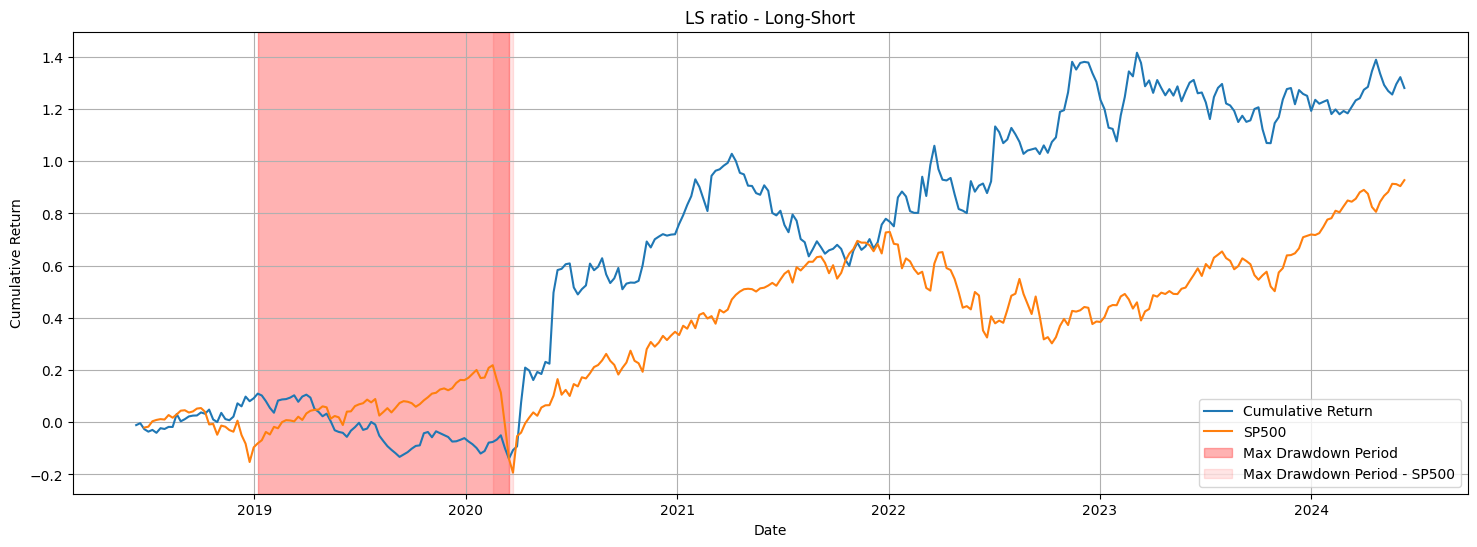

,Metric,Value
0,Average Daily Return,0.003042
1,Volatility (Daily),0.029475
2,Volatility (Annualized),0.212546
3,Cumulative Return,1.280820
4,Sharpe Ratio,0.805079
5,Maximum Drawdown,-0.224850


In [108]:
#stock_weights = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0,0,0,0,0,0,0,0,0,0]
stock_weights = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1]
#stock_weights = [0.2,0.2,0.2,0.2,0.2,-0.2,-0.2,-0.2,-0.2,-0.2]

return_s = backtestingwithtfsl_3(df_with_DLS , factor_weights= 1 , stock_weights= stock_weights, trading_fee=0.025/100, stop_loss=0.05)
metric = perf_m_s(return_s, sp500_weekly, "LS ratio - Long-Short")

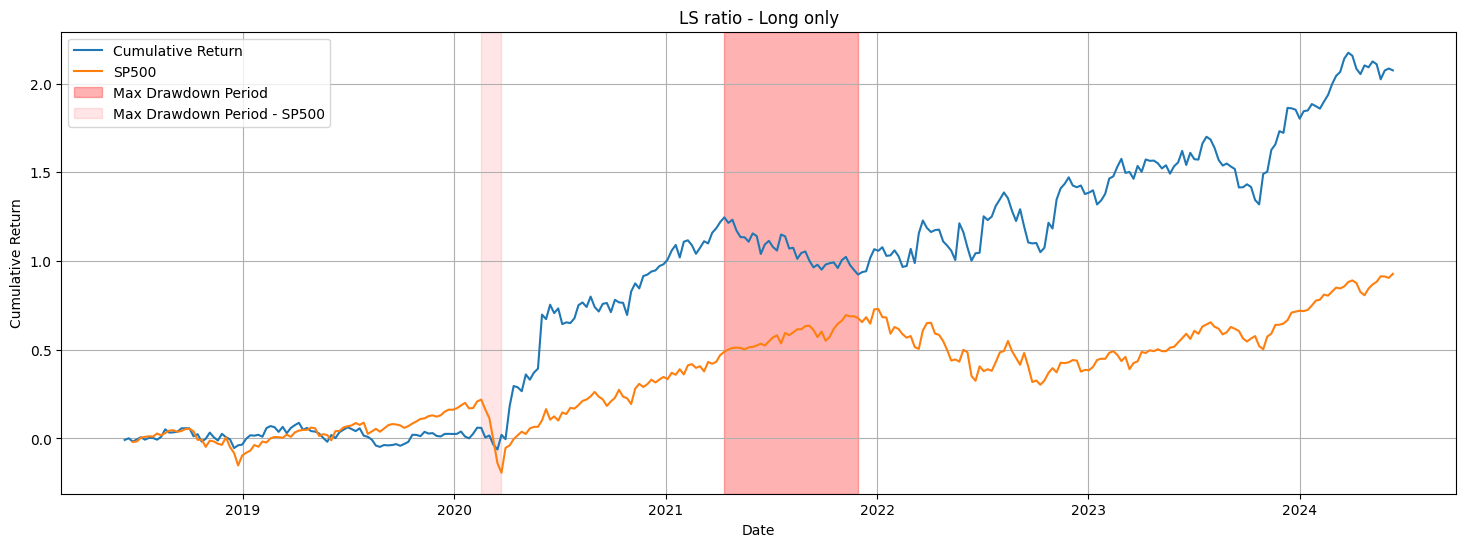

,Metric,Value
0,Average Daily Return,0.004019
1,Volatility (Daily),0.030235
2,Volatility (Annualized),0.218027
3,Cumulative Return,2.074238
4,Sharpe Ratio,1.063608
5,Maximum Drawdown,-0.143663


In [107]:
stock_weights = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0,0,0,0,0,0,0,0,0,0]
# stock_weights = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1]
#stock_weights = [0.2,0.2,0.2,0.2,0.2,-0.2,-0.2,-0.2,-0.2,-0.2]

return_s_long_only = backtestingwithtfsl_3(df_with_DLS , factor_weights= 1 , stock_weights= stock_weights, trading_fee=0.025/100, stop_loss=0.05)
metric_s_long_only = perf_m_s(return_s_long_only, sp500_weekly, "LS ratio - Long only")

##### <b>RSI Strategy

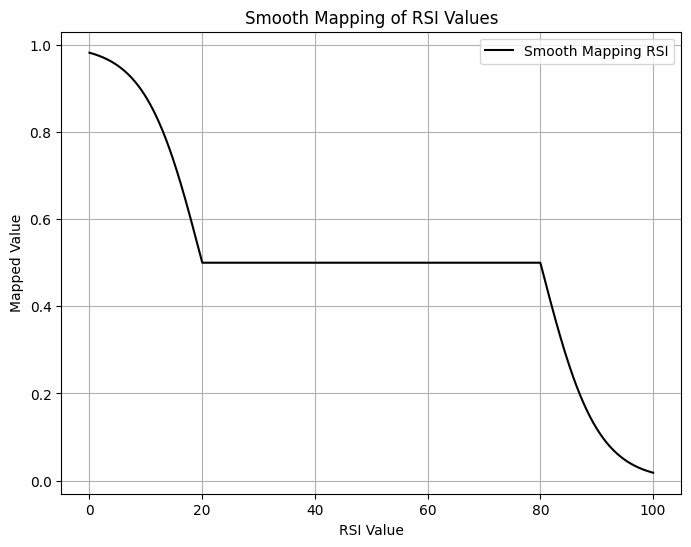

In [58]:
import matplotlib.pyplot as plt

def smooth_mapping_rsi(x):
    if 0 <= x <= 20:
        return 1 / (1 + np.exp((x - 20) / 5))
    elif 20 < x <= 80:
        return 0.5
    elif 80 < x <= 100:
        return 1 / (1 + np.exp((x - 80) / 5))
    else:
        raise ValueError("Input out of bounds")

# Generate RSI values from 0 to 100
rsi_values = np.linspace(0, 100, 1000)

# Apply the smooth_mapping_rsi function to each RSI value
mapped_values = np.array([smooth_mapping_rsi(x) for x in rsi_values])

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(rsi_values, mapped_values, label='Smooth Mapping RSI', color = 'black')
plt.xlabel('RSI Value')
plt.ylabel('Mapped Value')
plt.title('Smooth Mapping of RSI Values')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
def smooth_mapping_rsi(x):
    if 0 <= x <= 20:
        return 1 / (1 + np.exp((x - 20) / 5))
    elif 20 < x <= 80:
        return 0.5
    elif 80 < x <= 100:
        return 1 / (1 + np.exp((x - 80) / 5))
    else:
        raise ValueError("Input out of bounds")

df = raw_data.copy()
df = df[df["Date"] >= '2018-06-01']
df_with_RSI = pd.DataFrame()

for ticker in df["Ticker"].unique():
    df_filtered = df[df["Ticker"] == ticker]
    delta = df_filtered['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df_filtered['rsi'] = (100 - (100 / (1 + rs)))
    df_filtered.dropna(inplace = True)
    df_filtered['Norm_ret'] = (df_filtered['Close'] - df_filtered['Open']) / df_filtered['Open'] 
    df_filtered['RSI_normal'] = df_filtered['rsi'].apply(lambda x : smooth_mapping_rsi(x))
    df_with_RSI = pd.concat([df_with_RSI, df_filtered], axis = 0)

df_with_RSI = df_with_RSI[df_with_RSI["Ticker"] != "QRVO"]

In [30]:
def backtestingwithtfsl_3_rsi(df, factor_weights, stock_weights, trading_fee=0.025/100, stop_loss = 0.02):
    dfs = df.copy()
    dfs.reset_index(inplace = True)
    dfs['ranking_parameter'] = dfs['RSI_normal']
    dfs['next_date'] = dfs['Date'].shift(-1)
    dfs['next_Norm_ret'] = dfs['Norm_ret'].shift(-1)
    dfs['next_open'] = dfs['Open'].shift(-1)
    dfs['next_low'] = dfs['Low'].shift(-1)
    dfs['next_high'] = dfs['High'].shift(-1)
    ranking_df = dfs.pivot(index="Date", columns='Ticker', values='ranking_parameter')
    # ranking_df = ranking_df[ranking_df.isnull().mean(axis=1) < 0.9]
    # display(dfs)
    # display(ranking_df)
    portfolio_return = {}
    portfolio_return["Date"] = []
    portfolio_return["Daily Return"] = []

    for date in ranking_df[0:-1].index:
        dfs_filter = dfs[dfs['Date'] == date]
        top_5 = dfs_filter.nlargest(10, 'ranking_parameter')
        bottom_5 = dfs_filter.nsmallest(10, 'ranking_parameter')
        selected_stocks = pd.concat([top_5, bottom_5])
        # display(selected_stocks)
        return_next_day = selected_stocks['next_Norm_ret'].reset_index(drop=True)
        price_open= selected_stocks['next_open'].reset_index(drop=True)
        price_low = selected_stocks['next_low'].reset_index(drop=True)
        price_high = selected_stocks['next_high'].reset_index(drop=True)

        # Determine if stop-loss is hit
        stop_loss_long = (price_low / price_open - 1) < -stop_loss
        stop_loss_short = (price_high / price_open - 1) > stop_loss
        
        adjusted_returns = return_next_day.copy()
        adjusted_returns[:10] = adjusted_returns[:10].where(~stop_loss_long[:10], -stop_loss)
        adjusted_returns[10:] = adjusted_returns[10:].where(~stop_loss_short[10:], stop_loss)

        # Calculate returns including trading fees
        gross_return = (pd.Series(stock_weights) * adjusted_returns).values.sum()
        trade_cost = trading_fee * 2 * len(selected_stocks) * 0.1  # 2 trades (entry and exit) per stock
        net_return = gross_return - trade_cost

        portfolio_return["Date"].append(selected_stocks["next_date"].iloc[0])
        portfolio_return["Daily Return"].append(net_return)

        # if date == ranking_df.iloc[105,:].name:
        #     display(selected_stocks)
        #     display(return_next_day)
        #     display(price_open)
        #     display(price_low)
        #     display(stop_loss_long)
        #     display(stop_loss_short)
        #     display(adjusted_returns)
        #     display(gross_return)
        #     display(trade_cost)
        #     display(net_return)

    return_df = pd.DataFrame(portfolio_return)
    return_df.set_index("Date", inplace=True)
    
    return return_df

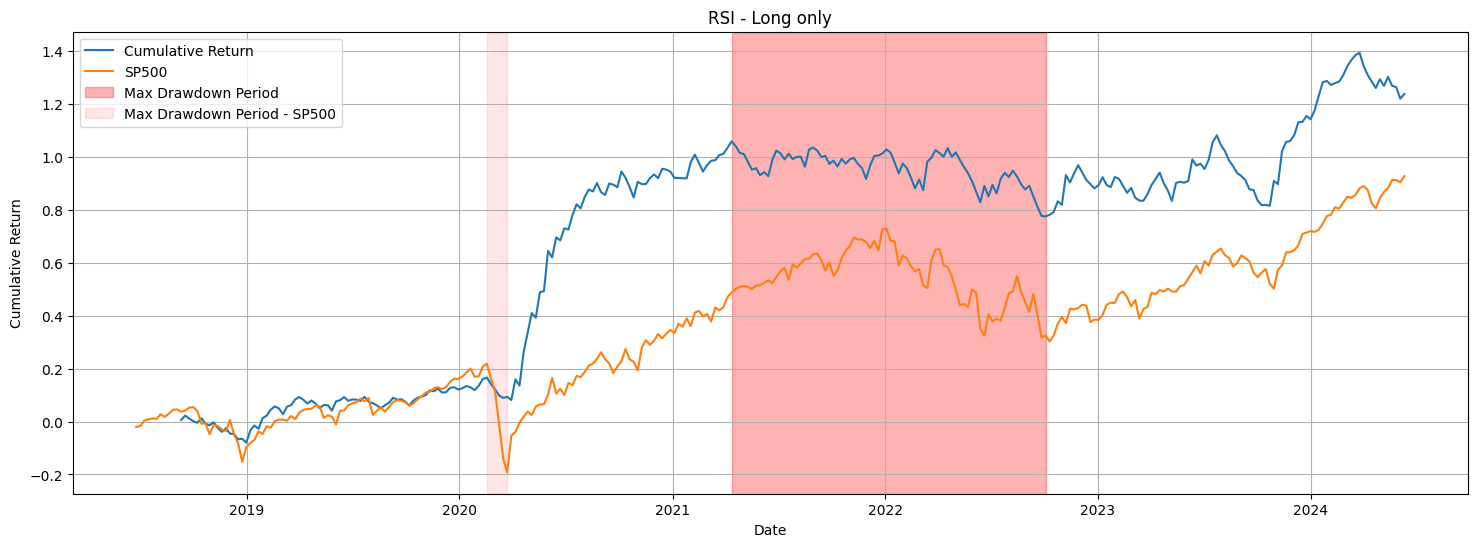

,Metric,Value
0,Average Daily Return,0.002873
1,Volatility (Daily),0.019890
2,Volatility (Annualized),0.143432
3,Cumulative Return,1.238419
4,Sharpe Ratio,1.121671
5,Maximum Drawdown,-0.137955


In [67]:
# backtesting rsi strategy

stock_weights = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0,0,0,0,0,0,0,0,0,0]
# stock_weights = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1]
#stock_weights = [0.2,0.2,0.2,0.2,0.2,-0.2,-0.2,-0.2,-0.2,-0.2]

return_s_rsi = backtestingwithtfsl_3_rsi(df_with_RSI , factor_weights= 1 , stock_weights= stock_weights, trading_fee=0.025/100, stop_loss=0.02)
metric = perf_m_s(return_s_rsi, sp500_weekly, "RSI - Long only")

In [32]:
# merge return of the strategy together

port = pd.merge(return_s, return_s_rsi, left_index=True, right_index=True)
port = pd.merge(port, return_s_long_only, left_index=True, right_index=True)
port = port.rename(columns={"Daily Return_x":"DLS_LS", "Cumulative Return_x":"Cumulative DLS_LS", "Daily Return_y":"RSI_L", "Cumulative Return_y":"Cumulative RSI_L", "Daily Return":"DLS_L", "Cumulative Return":"Cumulative DLS_L"})
port

,DLS_LS,Cumulative DLS_LS,RSI_L,Cumulative RSI_L,DLS_L,Cumulative DLS_L
Date,,,,,,
2018-09-10,0.010467,0.022373,0.005808,0.005808,0.003160,0.037468
2018-09-17,0.003039,0.025480,0.016523,0.022428,0.018610,0.056775
2018-09-24,0.000553,0.026047,-0.010899,0.011284,0.000580,0.057388
2018-10-01,0.011310,0.037652,-0.009725,0.001449,-0.000912,0.056424
2018-10-08,-0.004806,0.032665,-0.005805,-0.004363,-0.042249,0.011791
...,...,...,...,...,...,...
2024-05-13,-0.009985,1.269550,0.014971,1.302873,-0.005181,2.108482
2024-05-20,-0.006017,1.255893,-0.014575,1.269309,-0.027233,2.023828
2024-05-27,0.017523,1.295423,-0.002258,1.264184,0.016447,2.073563


In [16]:
# export data

port.to_csv("strategy return_2.csv")